## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([256, 1, 28, 28])
torch.Size([256])
256


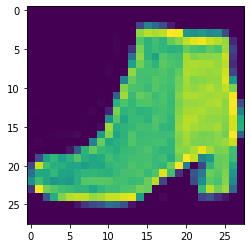

In [7]:
import matplotlib.pyplot as plt
inputs, classes = next(iter(train_loader))   
plt.imshow(inputs[0][0])


In [8]:
def plot_loss(loss, name = None):
  # Visualize
  if name is not None: 
    plt.plot(loss,label = name)
  else:
    plt.plot(loss)
  plt.title("Losses")
  plt.xlabel("#iteration")
  plt.ylabel("loss")
  plt.legend()

In [9]:
from sklearn.metrics import accuracy_score

In [10]:
def train_loop(data_loader, valid_loader, model, optimizer, loss_func, n_epochs=10, scheduler = None): 
  train_loss_history = []
  test_loss_history = []
  train_acc_history = []
  test_acc_history = []

  
  for i in range(n_epochs):
    train_loss = 0.0
    train_acc = 0.0
    model.train()     # Optional when not using Model Specific layer
    for data,label in data_loader:
      optimizer.zero_grad()
      # Forward
      output = model(data.to(device))
      loss = loss_func(output, label.to(device))
      
      # Backward
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * data.size(0)

      pred = torch.argmax(output, dim=1)
      train_acc += accuracy_score(label, pred.cpu())


    if scheduler is not None: 
      scheduler.step()
    
    valid_loss = 0.0
    valid_acc = 0.0
    model.eval()    
    for data, label in valid_loader:
        output = model(data.to(device))
        loss = loss_func(output, label.to(device))
        pred = torch.argmax(output, dim=1)

        valid_loss += loss.item() * data.size(0)
        pred = torch.argmax(output, dim=1)
        valid_acc += accuracy_score(label, pred.cpu())

    
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(test_loader.sampler)
    
    train_acc = train_acc / len(train_loader)
    valid_acc = valid_acc / len(test_loader)



    train_loss_history.append(train_loss)
    test_loss_history.append(valid_loss)
    train_acc_history.append(train_acc)
    test_acc_history.append(valid_acc)

    print(f'Epoch {i}')
    print(f'Current train loss: {train_loss_history[-1]:.5f}, validation loss: {test_loss_history[-1]:.5f}, accuracy: {test_acc_history[-1]:.5f}')

  return train_loss_history, test_loss_history,train_acc_history, test_acc_history
    

In [11]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 512 µs (started: 2022-12-26 00:28:55 +00:00)


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [12]:
import torch.nn.functional as F

time: 644 µs (started: 2022-12-26 00:28:55 +00:00)


In [13]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(28*28, 28*5),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(28*5, 28),
            nn.BatchNorm1d(28),
            nn.ReLU(),
            nn.Linear(28, 10),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

time: 2.12 ms (started: 2022-12-26 00:28:56 +00:00)


In [14]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 140]         109,900
           Dropout-3                  [-1, 140]               0
              ReLU-4                  [-1, 140]               0
            Linear-5                   [-1, 28]           3,948
       BatchNorm1d-6                   [-1, 28]              56
              ReLU-7                   [-1, 28]               0
            Linear-8                   [-1, 10]             290
        LogSoftmax-9                   [-1, 10]               0
Total params: 114,194
Trainable params: 114,194
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.44
Estimated Total Size (MB): 0.45
-------------------------------------------

Your experiments come here:

In [15]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr = 0.05)
loss_func = nn.NLLLoss()
# Your experiments, training and validation loops here

time: 4.58 ms (started: 2022-12-26 00:28:59 +00:00)


In [16]:
train_loss_tiny, test_loss_tiny, train_acc_tiny, test_acc_tiny = train_loop(
    train_loader, test_loader, model, opt, loss_func, n_epochs = 20)

Epoch 0
Current train loss: 0.88106, validation loss: 0.65423, accuracy: 0.77275
Epoch 1
Current train loss: 0.51017, validation loss: 0.47286, accuracy: 0.83320
Epoch 2
Current train loss: 0.44498, validation loss: 0.52554, accuracy: 0.80508
Epoch 3
Current train loss: 0.41390, validation loss: 0.44028, accuracy: 0.84434
Epoch 4
Current train loss: 0.39540, validation loss: 0.45162, accuracy: 0.83174
Epoch 5
Current train loss: 0.37882, validation loss: 0.39986, accuracy: 0.85732
Epoch 6
Current train loss: 0.36461, validation loss: 0.38490, accuracy: 0.86357
Epoch 7
Current train loss: 0.35727, validation loss: 0.38000, accuracy: 0.86055
Epoch 8
Current train loss: 0.34914, validation loss: 0.38582, accuracy: 0.86299
Epoch 9
Current train loss: 0.34057, validation loss: 0.35868, accuracy: 0.87373
Epoch 10
Current train loss: 0.33381, validation loss: 0.40477, accuracy: 0.84922
Epoch 11
Current train loss: 0.32539, validation loss: 0.35512, accuracy: 0.87373
Epoch 12
Current train los

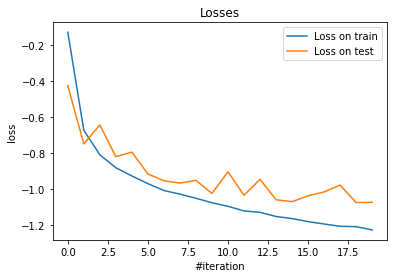

time: 161 ms (started: 2022-12-26 00:41:46 +00:00)


In [30]:
plot_loss(np.log(train_loss_tiny), 'Loss on train')
plot_loss(np.log(test_loss_tiny), 'Loss on test')

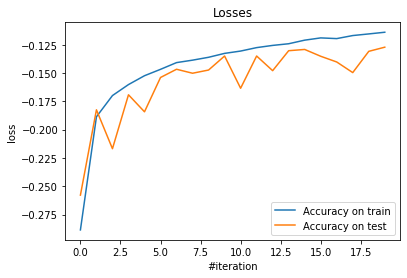

time: 200 ms (started: 2022-12-26 00:41:46 +00:00)


In [31]:
plot_loss(np.log(train_acc_tiny), 'Accuracy on train')
plot_loss(np.log(test_acc_tiny), 'Accuracy on test')

In [19]:
model.eval()
acc = 0
for data, label in test_loader:
        # Forward
        output = model(data.to(device))        
        # Convert output probabilities to predicted class
        pred = torch.argmax(output, dim=1)
        acc += accuracy_score(label, pred.cpu())
acc = acc / len(test_loader)
print(acc)

0.88056640625
time: 1.34 s (started: 2022-12-26 00:31:29 +00:00)


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

Ну, чтобы переобучить, надо сделать нейросеть толстую и неглубокую. Большие слои помогут запомнить датасет, а небольшая глубина не позволит сети узнать дополнительную скрытую информацию.

In [20]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 10*input_shape),
            nn.ReLU(),
            nn.Linear(10*input_shape, input_shape),
            nn.ReLU(),
            nn.Linear(input_shape, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

time: 1.94 ms (started: 2022-12-26 00:31:31 +00:00)


In [21]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 7840]       6,154,400
              ReLU-3                 [-1, 7840]               0
            Linear-4                  [-1, 784]       6,147,344
              ReLU-5                  [-1, 784]               0
            Linear-6                   [-1, 10]           7,850
        LogSoftmax-7                   [-1, 10]               0
Total params: 12,309,594
Trainable params: 12,309,594
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 46.96
Estimated Total Size (MB): 47.10
----------------------------------------------------------------
time: 128 ms (started: 2022-12-26 00:31:31 +00:00)


In [22]:
overfitted_model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.SGD(overfitted_model.parameters(), lr = 0.08)
loss_func = nn.NLLLoss()

train_loss_over, test_loss_over, train_acc_over, test_acc_over= train_loop(
    train_loader, test_loader, overfitted_model, opt, loss_func, n_epochs = 40)
# Your experiments, come here

Epoch 0
Current train loss: 0.83240, validation loss: 0.62364, accuracy: 0.76953
Epoch 1
Current train loss: 0.51578, validation loss: 0.53430, accuracy: 0.81270
Epoch 2
Current train loss: 0.45630, validation loss: 0.45559, accuracy: 0.83594
Epoch 3
Current train loss: 0.42033, validation loss: 0.52759, accuracy: 0.80391
Epoch 4
Current train loss: 0.39461, validation loss: 0.44282, accuracy: 0.84473
Epoch 5
Current train loss: 0.37430, validation loss: 0.41121, accuracy: 0.85547
Epoch 6
Current train loss: 0.36055, validation loss: 0.39554, accuracy: 0.85723
Epoch 7
Current train loss: 0.34605, validation loss: 0.40509, accuracy: 0.85068
Epoch 8
Current train loss: 0.33502, validation loss: 0.40551, accuracy: 0.85352
Epoch 9
Current train loss: 0.32595, validation loss: 0.37867, accuracy: 0.86250
Epoch 10
Current train loss: 0.31619, validation loss: 0.35518, accuracy: 0.87422
Epoch 11
Current train loss: 0.30577, validation loss: 0.40611, accuracy: 0.85107
Epoch 12
Current train los

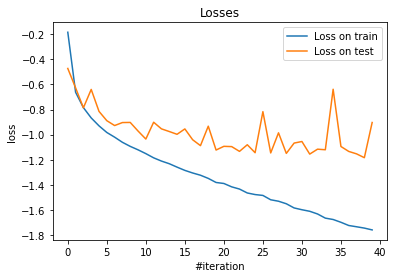

time: 169 ms (started: 2022-12-26 00:36:47 +00:00)


In [23]:
plot_loss(np.log(train_loss_over), 'Loss on train')
plot_loss(np.log(test_loss_over), 'Loss on test')

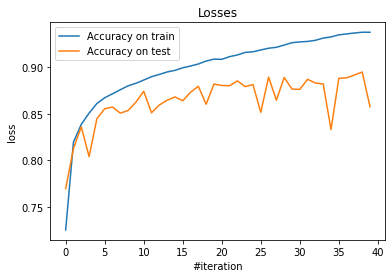

time: 190 ms (started: 2022-12-26 00:36:47 +00:00)


In [24]:
plot_loss(train_acc_over, 'Accuracy on train')
plot_loss(test_acc_over, 'Accuracy on test')

В целом, по графикам лоссов, как будто почти переобучаемся: точность на трейне растет, а на валидации нет (но и не падает, хотя вот эти скачки - тоже нехорошо)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [25]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 10*input_shape),
            nn.Dropout(p=0.9),
            nn.ReLU(),
            nn.Linear(10*input_shape, input_shape),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(input_shape, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

time: 1.41 ms (started: 2022-12-26 00:36:47 +00:00)


In [26]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 7840]       6,154,400
           Dropout-3                 [-1, 7840]               0
              ReLU-4                 [-1, 7840]               0
            Linear-5                  [-1, 784]       6,147,344
           Dropout-6                  [-1, 784]               0
              ReLU-7                  [-1, 784]               0
            Linear-8                   [-1, 10]           7,850
        LogSoftmax-9                   [-1, 10]               0
Total params: 12,309,594
Trainable params: 12,309,594
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 46.96
Estimated Total Size (MB): 47.16
-----------------------------------

In [27]:
model_fix = FixedNeuralNetwork().to(device)
opt = torch.optim.SGD(model_fix.parameters(), lr = 0.08)
loss_func = nn.NLLLoss()

train_loss_fix, test_loss_fix, train_acc_fix, test_acc_fix = train_loop(
    train_loader, test_loader, model_fix, opt, loss_func, n_epochs = 40)
# Your experiments, come here

Epoch 0
Current train loss: 0.97153, validation loss: 0.63493, accuracy: 0.76953
Epoch 1
Current train loss: 0.62297, validation loss: 0.52721, accuracy: 0.80830
Epoch 2
Current train loss: 0.55340, validation loss: 0.48663, accuracy: 0.82256
Epoch 3
Current train loss: 0.51732, validation loss: 0.46016, accuracy: 0.83750
Epoch 4
Current train loss: 0.48999, validation loss: 0.45898, accuracy: 0.83311
Epoch 5
Current train loss: 0.47153, validation loss: 0.42726, accuracy: 0.84473
Epoch 6
Current train loss: 0.45726, validation loss: 0.43213, accuracy: 0.84404
Epoch 7
Current train loss: 0.44424, validation loss: 0.42543, accuracy: 0.84668
Epoch 8
Current train loss: 0.43495, validation loss: 0.40676, accuracy: 0.85068
Epoch 9
Current train loss: 0.42347, validation loss: 0.40740, accuracy: 0.85098
Epoch 10
Current train loss: 0.41670, validation loss: 0.39329, accuracy: 0.85811
Epoch 11
Current train loss: 0.40894, validation loss: 0.39636, accuracy: 0.85752
Epoch 12
Current train los

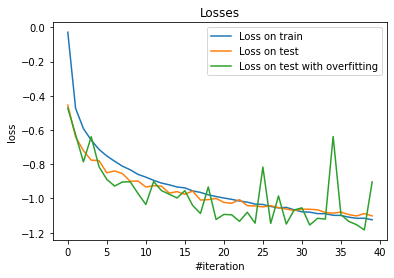

time: 179 ms (started: 2022-12-26 00:41:45 +00:00)


In [28]:
plot_loss(np.log(train_loss_fix), 'Loss on train')
plot_loss(np.log(test_loss_fix), 'Loss on test')
plot_loss(np.log(test_loss_over), 'Loss on test with overfitting')

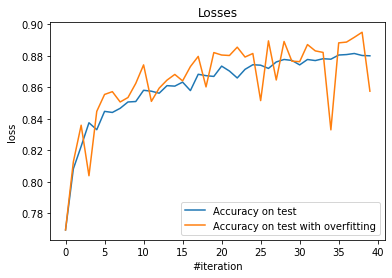

time: 168 ms (started: 2022-12-26 00:41:46 +00:00)


In [29]:
plot_loss(test_acc_fix, 'Accuracy on test')
plot_loss(test_acc_over, 'Accuracy on test with overfitting')

Ну чтож, dropout победил береобучение. Графики лоса и точности стали получше, хотя можно заметить, что в среднем точность стала меньше (лос чуть больше)

### Conclusions:
_Write down small report with your conclusions and your ideas._